In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit import Parameter
import sys  
sys.path.insert(0, '/Users/valerio/Documents/project_IBM_01/IBM_git/lib')
import utilities
from utilities import B, get_M, fidelity_count
from qiskit.ignis.verification.tomography import state_tomography_circuits
import numpy as np
from qiskit.ignis.verification.tomography import StateTomographyFitter
from qiskit.quantum_info import state_fidelity, Operator
from qiskit.opflow import One, Zero
import copy
from qiskit.ignis.mitigation.measurement import  complete_meas_cal
from qiskit.utils.mitigation.fitters import CompleteMeasFitter

In [2]:
# next we assume these values of TIME and N_STEPS for all the codes 
N_STEPS = 99
# since the calibration dosn't depend on time
# we can chose different time for evolution and calibration.
# we explain it in mitigation chapter.
TIME = np.pi/3
CALIBRATION_TIME = np.pi/3
# the initial state is fixed to 110

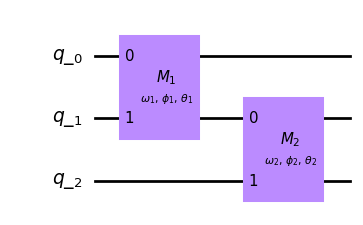

In [3]:
theta_1, phi_1, omega_1  = Parameter(r'$\theta_1$'), Parameter(r'$\phi_1$'), Parameter(r'$\omega_1$')
M1_qc = get_M(theta_1, phi_1, omega_1, name=r"$M_1$")

theta_2, phi_2, omega_2  = Parameter(r'$\theta_2$'), Parameter(r'$\phi_2$'), Parameter(r'$\omega_2$')
M2_qc = get_M(theta_2, phi_2, omega_2, name=r"$M_2$")

#building the circuit for the single state decomposition (SSD)
qr_U_best_SSD = QuantumRegister(3, name = "q_")
qc_U_best_SSD = QuantumCircuit(qr_U_best_SSD, name = r"$U_{best}$")

qc_U_best_SSD.append(M1_qc, [qr_U_best_SSD[0], qr_U_best_SSD[1]])
qc_U_best_SSD.append(M2_qc, [qr_U_best_SSD[1], qr_U_best_SSD[2]])

qc_U_best_SSD.draw(output = "mpl", style={"figwidth":5, "fontsize":11})

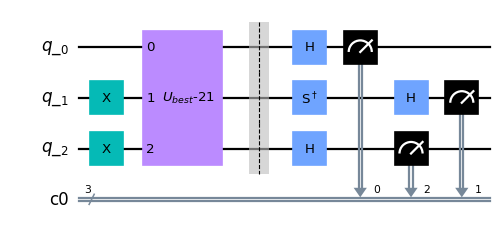

In [4]:
state_labels = ['000', '001', '010', '011', '100', '101', '110', '111']  
###################################################################
######################## Evolution tomography circuits preparation
# building numerically the trotter step matrix, and the whole operator (trotter step)^n_steps.
trotterized = utilities.trotterized_matrix(TIME, N_STEPS)
# getting the parameters for the gates M1 and M2 for the SSD, solving the equations described in 1.1).
theta_1_, theta_2_, phi_1_, phi_2_, omega_1_, omega_2_ = utilities.get_gates_parameters(trotterized, 
                                                                                        initial_state={"110": 1.0})
# substituting the parameters with the just computed
qc_U_best_SSD = qc_U_best_SSD.bind_parameters({
    theta_1: theta_1_,
    theta_2: theta_2_,
    phi_1: phi_1_,
    phi_2: phi_2_,
    omega_1: omega_1_,
    omega_2: omega_2_
})

# building the tomography circuits
qr_SSD = QuantumRegister(3, name="q_")
qc_SSD = QuantumCircuit(qr_SSD, name=r"$U_{best}$")
# prepare the initial state |110>
qc_SSD.x([qr_SSD[1],qr_SSD[2]])
qc_SSD.append(qc_U_best_SSD, qr_SSD)
# make the tomography circuits
qcs_tomo_SSD = state_tomography_circuits(qc_SSD, qr_SSD)
qcs_tomo_SSD[3].draw(output="mpl", style={"figwidth":7, "fontsize":12})

['000', '001', '000', '010', '000', '100']


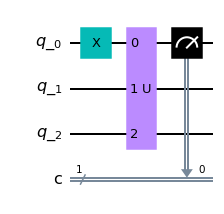

In [5]:
##################################################################
########## building the tensorized calibration circuits for both NIC and CIC
calibration_circuit_SSD, _ = utilities.get_evolution_circuit(CALIBRATION_TIME, N_STEPS, method="SSD")
calib_circuits_SSD_NIC, labels = utilities.get_tensorized_calibration_circuits(calibration_circuit_SSD, method="NIC", eigenvector="000")
calib_circuits_SSD_CIC, labels = utilities.get_tensorized_calibration_circuits(calibration_circuit_SSD, method="CIC")

print(labels)
calib_circuits_SSD_CIC[1].draw(output="mpl")

In [6]:

from qiskit import IBMQ, execute
from qiskit.providers.aer import QasmSimulator

IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-community',
                            group='ibmquantumawards', 
                            project='open-science-22')
backend_sim_noisy_jakarta = QasmSimulator.from_backend(provider.get_backend('ibmq_jakarta'))
backend_real_jakarta = provider.get_backend('ibmq_jakarta')

#################################################################
########################################### execute all the jobs
BACKEND = backend_sim_noisy_jakarta
shots = 20000

job_SSD_NIC=execute(calib_circuits_SSD_NIC, backend = BACKEND, shots=shots, initial_layout=[1,3,5])
job_SSD_CIC=execute(calib_circuits_SSD_CIC, backend = BACKEND, shots=shots, initial_layout=[1,3,5])
job_tomography_SSD=execute(qcs_tomo_SSD, backend = BACKEND, shots=shots, initial_layout=[1,3,5])

In [7]:
#################################################################
#################################### Mititgation of the raw results

# building the measured caliration martices from the results

def occurences_to_matrix_2x2(counts_dict_0, counts_dict_1):
    matrix = np.zeros([2,2])
    for key in counts_dict_0:
        matrix[int(key, 2), 0] = counts_dict_0[key]
    for key in counts_dict_1:
        matrix[int(key, 2), 1] = counts_dict_1[key]
    return matrix/sum(counts_dict_0.values())

n_qubits = 3
U_tilde_SSD_CIC = 1
U_tilde_SSD_NIC = 1
i=4
for i in np.arange(2*n_qubits, step=2):
    print(i)
    counts_SSD_NIC = job_SSD_NIC.result().get_counts()
    matrix2x2_NIC = occurences_to_matrix_2x2(counts_SSD_NIC[i], counts_SSD_NIC[i+1])
    U_tilde_SSD_NIC = np.kron(U_tilde_SSD_NIC, matrix2x2_NIC)

    counts_SSD_CIC = job_SSD_CIC.result().get_counts()
    matrix2x2_CIC = occurences_to_matrix_2x2(counts_SSD_CIC[i], counts_SSD_CIC[i+1])
    U_tilde_SSD_CIC = np.kron(U_tilde_SSD_CIC, matrix2x2_CIC)
    print(matrix2x2_CIC)

# make a fake meas_fitter

qr_cal = QuantumRegister(3)
calib_circuits_qiskit, state_labels = complete_meas_cal(qubit_list=[0,1,2], qr=qr_cal, circlabel='mcal')
job_qiskit=execute(calib_circuits_qiskit, backend = backend_sim_noisy_jakarta, shots=shots, initial_layout=[1,3,5])
meas_fitters_fake = CompleteMeasFitter(job_qiskit.result(), state_labels=state_labels)

0
[[0.96295 0.7369 ]
 [0.03705 0.2631 ]]
2
[[0.97765 0.9768 ]
 [0.02235 0.0232 ]]
4
[[0.92055 0.9218 ]
 [0.07945 0.0782 ]]


In [8]:
from sympy import Matrix
Matrix(U_tilde_SSD_CIC)

Matrix([
[0.866631607537125, 0.8678083926215, 0.865878130458, 0.867053892408, 0.66319209885675, 0.664092636713, 0.662615498556, 0.663515253456],
[0.074796459962875, 0.0736196748785, 0.074731429542, 0.073555667592, 0.05723818614325, 0.056337648287, 0.057188421444, 0.056288666544],
[0.019812014962875, 0.0198389173785, 0.020565492042, 0.020593417592, 0.01516119614325, 0.015181783287, 0.015737796444, 0.015759166544],
[0.001709917537125, 0.0016830151215, 0.001774947958, 0.001747022408, 0.00130851885675, 0.001287931713, 0.001358283556, 0.001336913456],
[0.033344099962875, 0.0333893773785, 0.033315109542, 0.033360347592, 0.23678360864325, 0.237105133287, 0.236577741444, 0.236898986544],
[0.002877832537125, 0.0028325551215, 0.002875330458, 0.002830092408, 0.02043610635675, 0.020114581713, 0.020418338556, 0.020097093456],
[0.000762277537125, 0.0007633126215, 0.000791267958, 0.000792342408, 0.00541309635675, 0.005420446713, 0.005618963556, 0.005626593456],
[  6.5789962875e-5,   6.47548785e-5,   

In [9]:



# U_ideal is the unitary matrix of the circuit qc_U, we will use it for the CIC method.
U_ideal_SSD = Operator(calibration_circuit_SSD)
# defining the tomography basis circuits.
qr_basi = QuantumRegister(3)
qc_basi = QuantumCircuit(qr_basi)
tomography_basis = state_tomography_circuits(qc_basi, qr_basi)

# compute the probability matrix of U_ideal and the inverse of it.
U_ideal_SSD_abs = np.abs(U_ideal_SSD)**2
U_ideal_SSD_abs_inv = np.linalg.inv(U_ideal_SSD_abs)
# built the calibration matrix in the computational basis for both CIC and NIC methods.
C_SSD_CIC = np.dot(U_tilde_SSD_CIC, U_ideal_SSD_abs_inv)
C_SSD_NIC = U_tilde_SSD_NIC
# building the fast tomography circuits calibration.
# next are computed the calibration matrices in all the tomography basis,
# and after are applyed to the raw result for both CIC and NIC.
raw_result_SSD = job_tomography_SSD.result()
NIC_result_SSD = copy.deepcopy(raw_result_SSD)
CIC_result_SSD = copy.deepcopy(raw_result_SSD)
for i, basis in enumerate(tomography_basis):
    basis.remove_final_measurements()
    # building the unitary matrix of the basis and the inverse.
    base_matrix_amplitudes = Operator(basis)
    base_matrix_amplitudes_inverse = np.linalg.inv(base_matrix_amplitudes)
    # building the probability matrices.
    base_matrix = np.abs(base_matrix_amplitudes)**2
    base_matrix_inverse = np.abs(base_matrix_amplitudes_inverse)**2
    # change the basis of the calibration matrices for NIC and CIC.
    C_basis_CIC = np.linalg.multi_dot([base_matrix, C_SSD_CIC,  base_matrix_inverse])
    C_basis_NIC = np.linalg.multi_dot([base_matrix, C_SSD_NIC,  base_matrix_inverse])
    # changing the meas_fitter_SSD_NIC calibration matrix with the new calibration matrix. 
    meas_fitter_NIC_aus = copy.deepcopy(meas_fitters_fake)
    meas_fitter_NIC_aus._tens_fitt.cal_matrices[0]=C_basis_NIC
    # changing the meas_fitter_SSD_CIC calibration matrix with the new calibration matrix. 
    meas_fitter_CIC_aus = copy.deepcopy(meas_fitters_fake)
    meas_fitter_CIC_aus._tens_fitt.cal_matrices[0]=C_basis_CIC
    # computing the new counts for both the mitigation techniques
    old_counts=raw_result_SSD.get_counts(basis)
    new_counts_NIC = meas_fitter_NIC_aus.filter.apply(old_counts, method="least_squares")
    new_counts_CIC = meas_fitter_CIC_aus.filter.apply(old_counts, method="least_squares")
    NIC_result_SSD.results[i].data.counts = new_counts_NIC
    CIC_result_SSD.results[i].data.counts = new_counts_CIC

In [10]:
target_state = (One^One^Zero).to_matrix()  # (|q_5,q_3,q_1> = |110>)
# compute the fidelity
fid_raw = fidelity_count(raw_result_SSD, qcs_tomo_SSD, target_state)
fid_NIC = fidelity_count(NIC_result_SSD, qcs_tomo_SSD, target_state)
fid_CIC = fidelity_count(CIC_result_SSD, qcs_tomo_SSD, target_state)
# print the result
print(f"decomposition method: Single State Decomposition\nevolution time = {TIME/np.pi:.3} pi\nNumber of trotter steps = {N_STEPS}\n")
print(f"fidelity of raw results: {fid_raw} \nfidelity with NIC method: {fid_NIC}\nfidelity with CIC method: {fid_CIC}   this is the fidelity score for the challenge.")

decomposition method: Single State Decomposition
evolution time = 0.333 pi
Number of trotter steps = 99

fidelity of raw results: 0.21933818604890923 
fidelity with NIC method: 0.257339321404469
fidelity with CIC method: 9.435692465888576e-09   this is the fidelity score for the challenge.
